### Project 1

Background:

ACME is one of the fastest growing startups in the logistics and delivery domain. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

Goals:

Predict if a customer is happy or not based on the answers they give to questions asked. 
Which questions/features are more important when predicting a customer’s happiness? 
Is there any question that we can remove in our next surve? 
What is the minimal set of attributes/features that would preserve the most information about the problem?

Success Metrics:

Reach 73% accuracy score or above

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pycaret

from scipy import stats
from scipy.stats import skew

In [3]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

In [4]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Y: target attribute with values 0 for unhappy and 1 for happy customers\
X1: my order was delievered on time\
X2: contents of my order was as I expected\
X3: I ordered everything I wanted to order\
X4: I paid a good price for my order\
X5: I am satisfied with my courier\
X6: the app makes ordering easy for me

In [5]:
# rename
new_names = ['customer_happiness', 'delivered_ontime', 'content_match', 'order_complete', 'price_sat', 'courier_sat', 'app_sat']
old_names = list(df.columns)
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [6]:
df.head()

,customer_happiness,delivered_ontime,content_match,order_complete,price_sat,courier_sat,app_sat
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [7]:
# check data info, data types, and NAs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   customer_happiness  126 non-null    int64
 1   delivered_ontime    126 non-null    int64
 2   content_match       126 non-null    int64
 3   order_complete      126 non-null    int64
 4   price_sat           126 non-null    int64
 5   courier_sat         126 non-null    int64
 6   app_sat             126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [8]:
df.isnull().sum()

customer_happiness    0
delivered_ontime      0
content_match         0
order_complete        0
price_sat             0
courier_sat           0
app_sat               0
dtype: int64

### Data Visualization and Exploratory Data Analysis

#### distribution of happy and unhappy customers

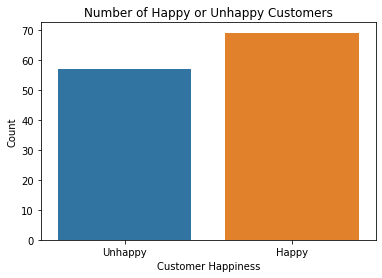

In [9]:
sns.countplot(x = 'customer_happiness', data = df)
plt.xlabel('Customer Happiness')
plt.ylabel('Count')
plt.xticks([0,1],['Unhappy', 'Happy'])
plt.title("Number of Happy or Unhappy Customers")
plt.show()

We have an imbalanced dataset with more happy customers than unhappy customers. We will do some resampling later to balance them out.

Text(0, 0.5, 'Count')

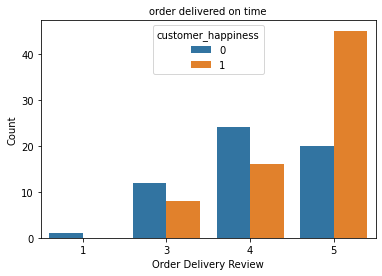

In [10]:
g2 = sns.countplot(x='delivered_ontime', hue='customer_happiness', data=df)
g2.set_title("order delivered on time", fontsize=10)
g2.set_xlabel("Order Delivery Review", fontsize=10)
g2.set_ylabel("Count", fontsize=10)


Happy customers likely to give a higher score, while unhappy customers tend to give a middle score

Text(0, 0.5, 'Count')

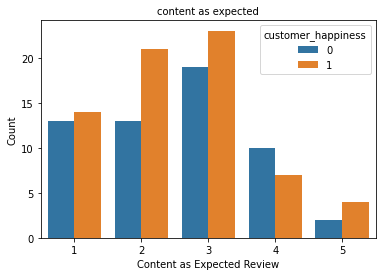

In [11]:
g3 = sns.countplot(x='content_match', hue='customer_happiness', data=df)
g3.set_title("content as expected", fontsize=10)
g3.set_xlabel("Content as Expected Review", fontsize=10)
g3.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

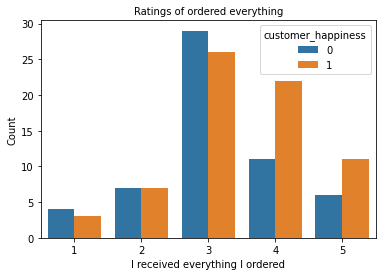

In [12]:
g4 = sns.countplot(x='order_complete', hue='customer_happiness', data=df)
g4.set_title("Ratings of ordered everything", fontsize=10)
g4.set_xlabel("I received everything I ordered", fontsize=10)
g4.set_ylabel("Count", fontsize=10)


Text(0, 0.5, 'Count')

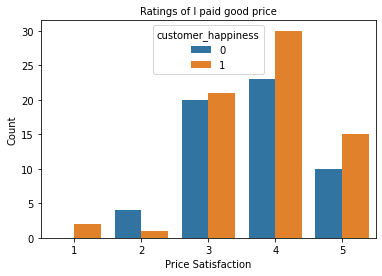

In [13]:
g5 = sns.countplot(x='price_sat', hue='customer_happiness', data=df)
g5.set_title("Ratings of I paid good price", fontsize=10)
g5.set_xlabel("Price Satisfaction", fontsize=10)
g5.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

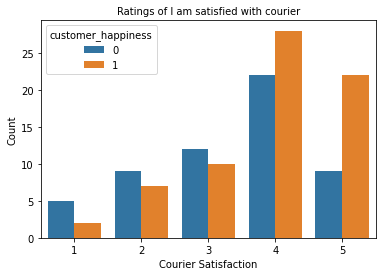

In [14]:
g6 = sns.countplot(x='courier_sat', hue='customer_happiness', data=df)
g6.set_title("Ratings of I am satisfied with courier", fontsize=10)
g6.set_xlabel("Courier Satisfaction", fontsize=10)
g6.set_ylabel("Count", fontsize=10)

Text(0, 0.5, 'Count')

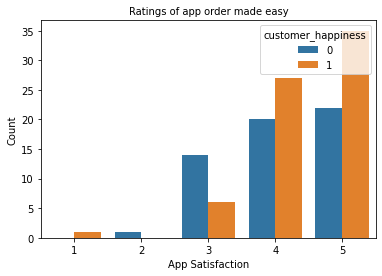

In [15]:
g7 = sns.countplot(x='app_sat', hue='customer_happiness', data=df)
g7.set_title("Ratings of app order made easy", fontsize=10)
g7.set_xlabel("App Satisfaction", fontsize=10)
g7.set_ylabel("Count", fontsize=10)

It looks like happy customers tend to give higher scores for X1, X5 attributes

#### Correlations Between Variables

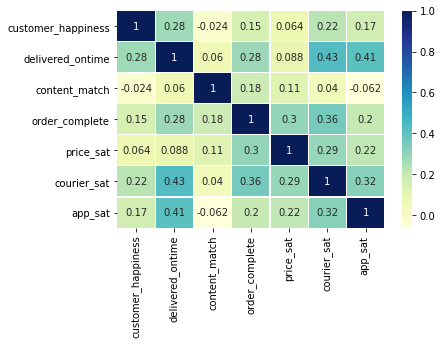

In [16]:
# check for correlations
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

It looks like X1 is most correlated with Y, so we consider to use X1 along first and check for the performance

#### data skewness

In [17]:
df.skew().sort_values(ascending = False)

content_match         0.271000
customer_happiness   -0.193659
order_complete       -0.199536
price_sat            -0.422240
courier_sat          -0.699999
app_sat              -0.957590
delivered_ontime     -1.058468
dtype: float64

Delivery Time is highly negatively skewed, Courier Satisfaction, App Satisfaction, Price Satisfaction are moderately skewed, content_match and order_complete are slightly skewed or normally distributed.

#### bootstrap resampling

In [18]:
# calculate the mean of happiness score
mean = df['customer_happiness'].values.mean()
print('The mean of the dataset is ' + str(mean))

The mean of the dataset is 0.5476190476190477


Since we have a small dataset, we will apply bootstrap method to replicate the experiment and look at the distribution of the means

In [19]:
# bootstrap method: re-sample points with replacement
def bootstrap(sample):
    sample_mean = []
    for i in range(500):
        sample_n = np.random.choice(sample, len(sample))
        sample_mean.append(sample_n.mean())
    return sample_mean

In [20]:
# 95% CI of the means
sample = bootstrap(df['customer_happiness'].values)
sample_dist = sorted(sample)
lb = np.quantile(sample_dist, 0.025)
ub = np.quantile(sample_dist, 0.975)
print('The 95% confidence interval is between {} and {}, so we can conclude that 95% of times that mean reviews will lie in this range'.format(lb, ub))

The 95% confidence interval is between 0.4640873015873016 and 0.6428571428571429, so we can conclude that 95% of times that mean reviews will lie in this range


(array([  5.,   8.,  40.,  76., 102., 132.,  89.,  30.,  12.,   6.]),
 array([0.4047619 , 0.43333333, 0.46190476, 0.49047619, 0.51904762,
        0.54761905, 0.57619048, 0.6047619 , 0.63333333, 0.66190476,
        0.69047619]),
 <a list of 10 Patch objects>)

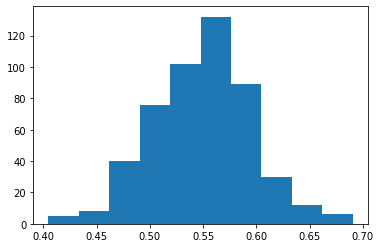

In [21]:
plt.hist(sample_dist)

The median is aroud 0.55

### Feature Engineering

In [22]:
# skewness transformation using stats.boxcox
d1, l1 = stats.boxcox(df['delivered_ontime'])
d2, l2 = stats.boxcox(df['price_sat'])
d3, l3 = stats.boxcox(df['courier_sat'])
d4, l4 = stats.boxcox(df['app_sat'])

df['delivered_ontime'] = d1
df['price_sat'] = d2
df['courier_sat'] = d3
df['app_sat'] = d4

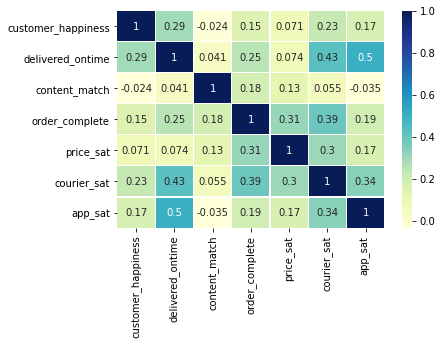

In [23]:
# check for correlations
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

We can see that content_match and price_sat have the lowest correlations with customer_happiness. We may consider dropping the two features when modelling.

In [24]:
df.dtypes

customer_happiness      int64
delivered_ontime      float64
content_match           int64
order_complete          int64
price_sat             float64
courier_sat           float64
app_sat               float64
dtype: object

#### Training and Testing Sets

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pycaret.classification import setup, compare_models, tune_model

In [26]:
# complete dataset
X1 = df.drop(['customer_happiness'], axis=1).values
y1 = df['customer_happiness'].values

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state=123)

In [27]:
# drop content_match and price_sat
X2 = df.drop(['customer_happiness', 'content_match', 'price_sat'], axis=1).values
y2 = df['customer_happiness'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=123)

In [28]:
# convert to dataframe
def convert_df(x, y):
    df = pd.DataFrame(x)
    df['y'] = y
    return df

In [29]:
df1 = convert_df(X_train1, y_train1)
df2 = convert_df(X_train2, y_train2)

### Modelling

we will use PyCaret package to search for the best ML model

In [30]:
# complete dataset
# setup - preprocessing
clf1 = setup(data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

In [31]:
# compare models
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333
qda,Quadratic Discriminant Analysis,0.4048,0.3833,0.4667,0.4833,0.4590,-0.2240,-0.2311,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333
qda,Quadratic Discriminant Analysis,0.4048,0.3833,0.4667,0.4833,0.4590,-0.2240,-0.2311,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333
gbc,Gradient Boosting Classifier,0.4286,0.3847,0.5500,0.4917,0.5124,-0.2014,-0.2388,0.053
qda,Quadratic Discriminant Analysis,0.4048,0.3833,0.4667,0.4833,0.4590,-0.2240,-0.2311,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
lda,Linear Discriminant Analysis,0.5976,0.5403,0.6583,0.6583,0.6372,0.1663,0.1705,0.021
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333
gbc,Gradient Boosting Classifier,0.4286,0.3847,0.5500,0.4917,0.5124,-0.2014,-0.2388,0.053


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
lda,Linear Discriminant Analysis,0.5976,0.5403,0.6583,0.6583,0.6372,0.1663,0.1705,0.021
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
et,Extra Trees Classifier,0.5167,0.5292,0.6333,0.5817,0.5877,-0.0193,-0.0471,0.287
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023
rf,Random Forest Classifier,0.4452,0.4604,0.5333,0.5300,0.5111,-0.1538,-0.1866,0.333


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lightgbm,Light Gradient Boosting Machine,0.6119,0.6049,0.6833,0.6600,0.6587,0.1898,0.1841,0.029
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
lda,Linear Discriminant Analysis,0.5976,0.5403,0.6583,0.6583,0.6372,0.1663,0.1705,0.021
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
et,Extra Trees Classifier,0.5167,0.5292,0.6333,0.5817,0.5877,-0.0193,-0.0471,0.287
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095
dt,Decision Tree Classifier,0.4595,0.4611,0.4667,0.5200,0.4798,-0.0577,-0.0755,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lightgbm,Light Gradient Boosting Machine,0.6119,0.6049,0.6833,0.6600,0.6587,0.1898,0.1841,0.029
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
lda,Linear Discriminant Analysis,0.5976,0.5403,0.6583,0.6583,0.6372,0.1663,0.1705,0.021
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
et,Extra Trees Classifier,0.5167,0.5292,0.6333,0.5817,0.5877,-0.0193,-0.0471,0.287
catboost,CatBoost Classifier,0.5071,0.4792,0.6333,0.5983,0.5980,-0.0409,-0.0619,0.533
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7214,0.6764,0.9000,0.7367,0.7952,0.3828,0.3997,0.073
lightgbm,Light Gradient Boosting Machine,0.6119,0.6049,0.6833,0.6600,0.6587,0.1898,0.1841,0.029
lr,Logistic Regression,0.5976,0.5486,0.6583,0.6583,0.6372,0.1663,0.1705,0.395
ridge,Ridge Classifier,0.5976,0.0000,0.6583,0.6583,0.6372,0.1663,0.1705,0.020
lda,Linear Discriminant Analysis,0.5976,0.5403,0.6583,0.6583,0.6372,0.1663,0.1705,0.021
svm,SVM - Linear Kernel,0.5833,0.0000,0.7500,0.5000,0.5956,0.0861,0.0977,0.023
nb,Naive Bayes,0.5548,0.6042,0.5750,0.5800,0.5589,0.0903,0.0685,0.022
et,Extra Trees Classifier,0.5167,0.5292,0.6333,0.5817,0.5877,-0.0193,-0.0471,0.287
catboost,CatBoost Classifier,0.5071,0.4792,0.6333,0.5983,0.5980,-0.0409,-0.0619,0.533
ada,Ada Boost Classifier,0.4738,0.3292,0.6333,0.5383,0.5691,-0.0959,-0.1326,0.095


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [32]:
# drop two features
clf2 = setup(data = df2, target = df2.columns[-1], html = False, silent = True, verbose = False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6452,0.7833,0.725,0.7121,0.688,0.2707,0.3068,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091
gbc,Gradient Boosting Classifier,0.6262,0.7097,0.6750,0.6121,0.6309,0.2303,0.2338,0.073
svm,SVM - Linear Kernel,0.5071,0.0000,0.6750,0.3910,0.4921,0.0087,0.0091,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
lda,Linear Discriminant Analysis,0.6452,0.7750,0.7250,0.7121,0.6880,0.2707,0.3068,0.025
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091
gbc,Gradient Boosting Classifier,0.6262,0.7097,0.6750,0.6121,0.6309,0.2303,0.2338,0.073


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
lda,Linear Discriminant Analysis,0.6452,0.7750,0.7250,0.7121,0.6880,0.2707,0.3068,0.025
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091
gbc,Gradient Boosting Classifier,0.6262,0.7097,0.6750,0.6121,0.6309,0.2303,0.2338,0.073


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lightgbm,Light Gradient Boosting Machine,0.6762,0.7715,0.7250,0.7300,0.7001,0.3404,0.3913,0.019
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
lda,Linear Discriminant Analysis,0.6452,0.7750,0.7250,0.7121,0.6880,0.2707,0.3068,0.025
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lightgbm,Light Gradient Boosting Machine,0.6762,0.7715,0.7250,0.7300,0.7001,0.3404,0.3913,0.019
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
lda,Linear Discriminant Analysis,0.6452,0.7750,0.7250,0.7121,0.6880,0.2707,0.3068,0.025
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6833,0.7986,0.7417,0.7183,0.7137,0.3368,0.3544,0.074
lightgbm,Light Gradient Boosting Machine,0.6762,0.7715,0.7250,0.7300,0.7001,0.3404,0.3913,0.019
qda,Quadratic Discriminant Analysis,0.6714,0.7097,0.6750,0.7205,0.6711,0.3241,0.3499,0.016
lr,Logistic Regression,0.6452,0.7833,0.7250,0.7121,0.6880,0.2707,0.3068,0.016
dt,Decision Tree Classifier,0.6452,0.6014,0.6833,0.6771,0.6670,0.2667,0.2683,0.014
ridge,Ridge Classifier,0.6452,0.0000,0.7250,0.7121,0.6880,0.2707,0.3068,0.014
lda,Linear Discriminant Analysis,0.6452,0.7750,0.7250,0.7121,0.6880,0.2707,0.3068,0.025
nb,Naive Bayes,0.6429,0.7639,0.6667,0.7300,0.6563,0.2852,0.3315,0.014
rf,Random Forest Classifier,0.6405,0.7153,0.7333,0.6433,0.6721,0.2518,0.2944,0.296
ada,Ada Boost Classifier,0.6286,0.6569,0.7250,0.6933,0.6740,0.2239,0.2560,0.091


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


Deal with imbalanced dataset

In [35]:
# Create a new column for happy and unhappy
df['happiness'] = df['customer_happiness'].map({0: 'unhappy', 1:'happy'})

In [37]:
# happy and unhappy customers
con1 = df['customer_happiness']==1
data_happy = df.loc[con1].reset_index(drop = True).drop('happiness', axis = 1)
con2 = df['customer_happiness']==0
data_unhappy = df.loc[con2].reset_index(drop = True).drop('happiness', axis = 1)

array1 = data_happy.values
array2 = data_unhappy.values

print(len(data_happy))
print(len(data_unhappy))

69
57


In [38]:
# We have more happy customers, so make balanced dataset on unhappy customers
# boostrapping, run 100 iterations

list_happy = []
list_unhappy = []

for i in range(100):
    idx = np.random.choice(np.arange(0,57))
    d = array1[idx]
    list_happy.append(d)
    
for i in range(100):
    idx = np.random.choice(np.arange(0,57))
    boot = array2[idx]
    list_unhappy.append(d) 


In [40]:
# select 57 samples

customers_happy = []
customers_unhappy = []


for i in range(57):
    idx = np.random.choice(np.arange(0, 100))
    d = list_happy[idx]
    customers_happy.append(d)
    

for i in range(57):
    idx = np.random.choice(np.arange(0, 100))
    d = list_unhappy[idx]
    customers_unhappy.append(d)

In [42]:
# Create dataframes
happy_df = pd.DataFrame(customers_happy)
happy_df.columns = df.columns[:-1]

unhappy_df = pd.DataFrame(customers_unhappy)
unhappy_df.columns = df.columns[:-1]

data_balanced = pd.concat([happy_df, unhappy_df], axis = 0).reset_index(drop = True)



In [68]:
happy_df.head()

,customer_happiness,delivered_ontime,content_match,order_complete,price_sat,courier_sat,app_sat
0,1.0,54.524775,2.0,2.0,4.619280,8.393210,27.741232
1,1.0,54.524775,3.0,3.0,2.775932,8.393210,6.752861
2,1.0,26.459624,4.0,3.0,4.619280,1.317663,15.062869
3,1.0,54.524775,2.0,3.0,2.775932,1.317663,27.741232
4,1.0,54.524775,2.0,3.0,2.775932,1.317663,27.741232


In [69]:
unhappy_df.head()

,customer_happiness,delivered_ontime,content_match,order_complete,price_sat,courier_sat,app_sat
0,1.0,54.524775,2.0,4.0,6.704308,8.39321,27.741232
1,1.0,54.524775,2.0,4.0,6.704308,8.39321,27.741232
2,1.0,54.524775,2.0,4.0,6.704308,8.39321,27.741232
3,1.0,54.524775,2.0,4.0,6.704308,8.39321,27.741232
4,1.0,54.524775,2.0,4.0,6.704308,8.39321,27.741232


In [66]:
data_balanced.head()

,customer_happiness,delivered_ontime,content_match,order_complete,price_sat,courier_sat,app_sat
0,1.0,54.524775,2.0,2.0,4.619280,8.393210,27.741232
1,1.0,54.524775,3.0,3.0,2.775932,8.393210,6.752861
2,1.0,26.459624,4.0,3.0,4.619280,1.317663,15.062869
3,1.0,54.524775,2.0,3.0,2.775932,1.317663,27.741232
4,1.0,54.524775,2.0,3.0,2.775932,1.317663,27.741232


In [67]:
data_balanced['customer_happiness'].mean()

1.0

In [44]:
data_balanced.dtypes

customer_happiness    float64
delivered_ontime      float64
content_match         float64
order_complete        float64
price_sat             float64
courier_sat           float64
app_sat               float64
dtype: object

In [53]:
# full model

data3_balanced = pd.get_dummies(data_balanced, columns = ['delivered_ontime','content_match', 'order_complete', 'app_sat',
                                       'price_sat', 'courier_sat'], drop_first = False)

X3 = data3_balanced.drop(columns = 'customer_happiness', axis = 1).values
y3 = data3_balanced['customer_happiness'].values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 123)

In [55]:
# drop content_match and price_sat

data4_balanced = data_balanced[['customer_happiness', 'courier_sat', 'content_match', 'delivered_ontime','app_sat']]

data4_balanced = pd.get_dummies(data4_balanced, columns = ['delivered_ontime','content_match', 'courier_sat', 'app_sat'], drop_first = False)

X4 = data4_balanced.drop(['customer_happiness'], axis=1).values
y4 = data4_balanced['customer_happiness'].values

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25, random_state=123)

In [56]:
# convert to data frames
df3 = convert_df(X_train3, y_train3)
df4 = convert_df(X_train4, y_train4)

In [57]:
# full model
clf3 = setup(data = df3, target = df3.columns[-1], html = False, silent = True, verbose = False)

best = compare_models()

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011
gbc,Gradient Boosting Classifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.050
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.050
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.158
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.050
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.158
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.033
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.050
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.158
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.033
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.074
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.021
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.020
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.170
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.025
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.050
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.158
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.033
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [58]:
# drop two features
clf4 = setup(data = df4, target = df4.columns[-1], html = False, silent = True, verbose = False)

best = compare_models()

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
gbc,Gradient Boosting Classifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.031
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010
qda,Quadratic Discriminant Analysis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.031
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.236
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
svm,SVM - Linear Kernel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.031
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.236
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.030
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.031
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.236
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.030
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.077
nb,Naive Bayes,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
dt,Decision Tree Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.016
ridge,Ridge Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.036
rf,Random Forest Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.181
ada,Ada Boost Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.017
lda,Linear Discriminant Analysis,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.031
et,Extra Trees Classifier,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.236
lightgbm,Light Gradient Boosting Machine,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.030
lr,Logistic Regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


Based on the model performance, we will use the dataset without the two features

In [61]:
# final model variables
X = df4.drop(columns = 'y', axis = 1).values
y = df4['y'].values

# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.svm import SVC

In [63]:
%%time
param_grid = {'n_neighbors':[5, 6, 7, 8, 9, 10], 'weights':['uniform', 'distance'], 'p':[1,2]}

knn = KNeighborsClassifier()

cv_knn = GridSearchCV(knn, param_grid, cv = 5)
cv_knn.fit(X_train2, y_train2)

print(cv_knn.best_params_)

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
CPU times: user 323 ms, sys: 9.51 ms, total: 332 ms
Wall time: 351 ms


In [64]:
knn_clf = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')
knn_clf.fit(X_train2, y_train2)
pred_knn = knn_clf.predict(X_test2)

In [65]:
print(classification_report(y_test2, pred_knn))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [45]:
print("Accuracy score {:.4f}".format(accuracy_score(y_test2, pred_knn)))

Accuracy score 0.6250


In [51]:
knn_prob = knn_clf.predict_proba(X_test2)[:,1]
fpr, tpr, threshold = roc_curve(y_test2, knn_prob)


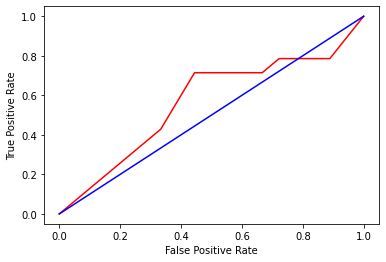

In [52]:
plt.plot(fpr, tpr, color = 'red')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [54]:
def gini(y, pred):
    fpr, tpr, thr = metrics.roc_curve(y, pred, pos_label=1)
    g = 2 * metrics.auc(fpr, tpr) -1
    return g

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

In [57]:
lgb = LGBMClassifier(n_estimators=90, silent=False, max_depth=5, num_leaves=31)

lgb.fit(X_train2, y_train2, eval_metric=gini_lgb)



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [58]:
pred_lgb=lgb.predict(X_test2)

In [59]:
print('LightGBM accuracy score: {:.4f}'.format(accuracy_score(y_test2, pred_lgb)))

LightGBM accuracy score: 0.5938


#### Voting Classifier

In [65]:
clf1 = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')

clf2 = LGBMClassifier(n_estimators=90, silent=False, max_depth=5, num_leaves=31)

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2)], voting = 'soft')

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [66]:
print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63        18
           1       0.56      0.71      0.63        14

    accuracy                           0.62        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.64      0.62      0.63        32



In [67]:
print('Voting accuracy score: {:.4f}'.format(accuracy_score(y_test2, pred_voting)))

Voting accuracy score: 0.6250


#### Weights to each classifier

In [1]:
weights1 = []
weights2 = []
scores = []

for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
            clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2)], voting = 'soft', weights = [i, j])
            clf_voting.fit(X_train, y_train)
            pred = clf_voting.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)

NameError: name 'np' is not defined

In [ ]:
test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['TestScore'] = scores

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2'])

# getting the rows where sum is equal to 1
condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

test_scores.sort_values(by = 'TestScore', ascending = False).head(10)

In [ ]:
# Create voting classifier

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2)], voting = 'soft', weights = [0.4, 0.3, 0.3])

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_voting))

### Conclusion



#### Final Model

In [64]:
#import pickle
#s = pickle.dumps(model4)
#from joblib import dump, load
#dump(model4, 'happycustomer')

#### Feature Importance